<center><h1>Gunadi_Eben_HW7</h1></center>

Name: Eben Gunadi
<br>
Github Username: egunadi
<br>
USC ID: 3976793880

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, hamming_loss
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statistics import mode
from scipy.spatial import distance_matrix

### (a) Download the Anuran Calls (MFCCs) Data Set

In [2]:
frogs_filepath = '../data/Frogs_MFCCs.csv'
frogs_df = pd.read_csv(frogs_filepath)

frogs_df.head()

MFCCs_ 1  MFCCs_ 2  MFCCs_ 3  MFCCs_ 4  MFCCs_ 5  MFCCs_ 6  MFCCs_ 7  \
0       1.0  0.152936 -0.105586  0.200722  0.317201  0.260764  0.100945   
1       1.0  0.171534 -0.098975  0.268425  0.338672  0.268353  0.060835   
2       1.0  0.152317 -0.082973  0.287128  0.276014  0.189867  0.008714   
3       1.0  0.224392  0.118985  0.329432  0.372088  0.361005  0.015501   
4       1.0  0.087817 -0.068345  0.306967  0.330923  0.249144  0.006884   

   MFCCs_ 8  MFCCs_ 9  MFCCs_10  ...  MFCCs_17  MFCCs_18  MFCCs_19  MFCCs_20  \
0 -0.150063 -0.171128  0.124676  ... -0.108351 -0.077623 -0.009568  0.057684   
1 -0.222475 -0.207693  0.170883  ... -0.090974 -0.056510 -0.035303  0.020140   
2 -0.242234 -0.219153  0.232538  ... -0.050691 -0.023590 -0.066722 -0.025083   
3 -0.194347 -0.098181  0.270375  ... -0.136009 -0.177037 -0.130498 -0.054766   
4 -0.265423 -0.172700  0.266434  ... -0.048885 -0.053074 -0.088550 -0.031346   

   MFCCs_21  MFCCs_22           Family      Genus         Species  RecordID  
0  0.118680  0.014038  Leptodactylidae  Adenomera  AdenomeraAndre         1  
1  0.082263  0.029056  Leptodactylidae  Adenomera  AdenomeraAndre         1  
2  0.099108  0.077162  Leptodactylidae  Adenomera  AdenomeraAndre         1  
3 -0.018691  0.023954  Leptodactylidae  Adenomera  AdenomeraAndre         1  
4  0.108610  0.079244  Leptodactylidae  Adenomera  AdenomeraAndre         1  

[5 rows x 26 columns]

In [4]:
frogs_df.shape

(7195, 26)

In [5]:
# Choose 70% of the data randomly as the training set

X_frogs_df = frogs_df.drop(columns=['Family', 'Genus', 'Species', 'RecordID'])
y_frogs_df = frogs_df[['Family', 'Genus', 'Species']]

X_train_frogs_df, X_test_frogs_df, y_train_frogs_df, y_test_frogs_df = train_test_split(X_frogs_df, y_frogs_df, test_size=0.3, random_state=42)

In [6]:
print(X_train_frogs_df.shape)
print(y_train_frogs_df.shape)
print(X_test_frogs_df.shape)
print(y_test_frogs_df.shape)

(5036, 22)
(5036, 3)
(2159, 22)
(2159, 3)


### (b) Train a classifier for each label

#### (i) Research

Research exact match and hamming score/ loss methods for evaluating multi-label classification and use them in evaluating the classifiers in this problem.

> Exact match looks at whether all labels are classified correctly in a given sample. On the other hand, hamming score/loss looks at whether each individual label was classified correctly.

#### (ii) Train a SVM for each of the labels

In [23]:
# Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation. You are welcome to try to solve the problem with both standardized and raw attributes and report the results.

# Per footnote 1:
# To choose parameter ranges for SVMs, train the SVM with very large and very small parameters on the whole training data and find very large and very small parameters for which the training accuracy is not below a threshold (e.g., 70%). Then one can select a fixed number of parameters (e.g., 20) between those points for cross validation.
# For the penalty parameter, usually one has to consider increments in log(λ). For example, if one found that the accuracy of a support vector machine will not be below 70% for λ = 10−3 and λ = 106, one has to choose log(λ) ∈ {−3, −2, . . . , 4, 5, 6}. For the Gaussian Kernel parameter, one usually chooses linear increments, e.g. σ ∈ {.1, .2, . . . , 2}. When both σ and λ are to be chosen using cross-validation, combinations of very small and very large λ’s and σ’s that keep the accuracy above a threshold (e.g.70%) can be used to determine the ranges for σ and λ. Please note that these are very rough rules of thumb, not general procedures.

# Per footnote 2:
# It seems that the data are already normalized. So, I will use the raw data for the SVM.

labels = ['Family', 'Genus', 'Species']
C_value_ranges = {}

for label in labels:
    # Train SVM with very large and very small parameters to identify acceptable range
    svm_large = SVC(C=1e6, gamma=1e-3)
    svm_small = SVC(C=1e-3, gamma=1e6)

    svm_large.fit(X_train_frogs_df, y_train_frogs_df[label])
    svm_small.fit(X_train_frogs_df, y_train_frogs_df[label])

    threshold_accuracy = 0.7

    # Determine the acceptable range for C (penalty parameter)
    if svm_large.score(X_train_frogs_df, y_train_frogs_df[label]) >= threshold_accuracy:
        C_value_ranges[label] = [1e3, 1e6]  # If large C is acceptable, set range accordingly
    elif svm_small.score(X_train_frogs_df, y_train_frogs_df[label]) >= threshold_accuracy:
        C_value_ranges[label] = [1e-6, 1e-3]  # If small C is acceptable, set range accordingly
    else:
        C_value_ranges[label] = [1e-3, 1e3]  # Default range if neither large nor small C is acceptable

In [29]:
gamma_value_range = np.linspace(0.1, 2, num=20)


In [34]:
best_params = {}
best_svms = {}

for label in labels:
    # Initialize the SVM classifier
    svm = SVC(kernel='rbf')

    # Create a parameter grid for GridSearchCV
    param_grid = {'C': C_value_ranges[label], 'gamma': gamma_value_range}

    # Perform GridSearchCV with SVM and parameter grid to
    # determine weights of the SVM penalty (C) and widths of the Gaussian Kernel (gamma)
    grid_search = GridSearchCV(svm, param_grid, cv=10)
    grid_search.fit(X_train_frogs_df, y_train_frogs_df[label])

    # Get best parameters from GridSearchCV
    best_params[label] = grid_search.best_params_

    # Train SVM with best parameters for the current label
    best_svm = SVC(C=best_params[label]['C'], gamma=best_params[label]['gamma'])
    best_svm.fit(X_train_frogs_df, y_train_frogs_df[label])
    best_svms[label] = best_svm

In [35]:
exact_match_count = 0
hamming_scores = []
hamming_losses = []

# Compute exact match score, Hamming score, and Hamming loss
for i in range(len(y_test_frogs_df)):
    true_labels = [y_test_frogs_df[label].iloc[i] for label in labels]
    predicted_labels = [best_svms[label].predict([X_test_frogs_df.iloc[i]])[0] for label in labels]

    # Check if all three labels match exactly
    if all(set(true_label) == set(predicted_label) for true_label, predicted_label in zip(true_labels, predicted_labels)):
        exact_match_count += 1

    # Compute Hamming score and Hamming loss
    hamming_scores.append(accuracy_score(true_labels, predicted_labels))
    hamming_losses.append(hamming_loss(true_labels, predicted_labels))

/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/User

In [36]:
# Calculate metrics
exact_match_score = exact_match_count / len(y_test_frogs_df)
average_hamming_score = sum(hamming_scores) / len(hamming_scores)
average_hamming_loss = sum(hamming_losses) / len(hamming_losses)

print("Exact Match Score:", exact_match_score)
print("Average Hamming Score:", average_hamming_score)
print("Average Hamming Loss:", average_hamming_loss)

Exact Match Score: 0.9893469198703103
Average Hamming Score: 0.991817199320673
Average Hamming Loss: 0.008182800679326849


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [38]:
best_params = {}
best_svms = {}

for label in labels:
    # Initialize the L1-penalized SVM classifier with a linear kernel
    svm = LinearSVC(penalty='l1', dual=False)

    # Create a parameter grid for GridSearchCV
    param_grid = {'C': C_value_ranges[label]}

    # Perform GridSearchCV with SVM and parameter grid to
    # determine weights of the SVM penalty (C)
    grid_search = GridSearchCV(svm, param_grid, cv=10)
    grid_search.fit(X_train_frogs_df, y_train_frogs_df[label])

    # Get best parameters from GridSearchCV
    best_params[label] = grid_search.best_params_

    # Train L1-penalized SVM with best parameters for the current label
    best_svm = LinearSVC(C=best_params[label]['C'], penalty='l1', dual=False)
    best_svm.fit(X_train_frogs_df, y_train_frogs_df[label])
    best_svms[label] = best_svm

/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

In [39]:
exact_match_count = 0
hamming_scores = []
hamming_losses = []

# Compute exact match score, Hamming score, and Hamming loss
for i in range(len(y_test_frogs_df)):
    true_labels = [y_test_frogs_df[label].iloc[i] for label in labels]
    predicted_labels = [best_svms[label].predict([X_test_frogs_df.iloc[i]])[0] for label in labels]

    # Check if all three labels match exactly
    if all(set(true_label) == set(predicted_label) for true_label, predicted_label in zip(true_labels, predicted_labels)):
        exact_match_count += 1

    # Compute Hamming score and Hamming loss
    hamming_scores.append(accuracy_score(true_labels, predicted_labels))
    hamming_losses.append(hamming_loss(true_labels, predicted_labels))

/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearSVC was fitted with featur

In [40]:
# Calculate metrics
exact_match_score = exact_match_count / len(y_test_frogs_df)
average_hamming_score = sum(hamming_scores) / len(hamming_scores)
average_hamming_loss = sum(hamming_losses) / len(hamming_losses)

print("Exact Match Score:", exact_match_score)
print("Average Hamming Score:", average_hamming_score)
print("Average Hamming Loss:", average_hamming_loss)

Exact Match Score: 0.9101435849930524
Average Hamming Score: 0.9428747877103603
Average Hamming Loss: 0.05712521228964024


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [43]:
best_params = {}
best_svms = {}

for label in labels:
    # Initialize the SMOTE oversampler
    smote = SMOTE(random_state=42)

    # Create a pipeline with SMOTE and SVM
    pipeline = Pipeline([('smote', smote), ('svm', SVC(kernel='rbf'))])

    # Create a parameter grid for GridSearchCV
    param_grid = {'svm__C': C_value_ranges[label], 'svm__gamma': gamma_value_range}

    # Perform GridSearchCV with SVM and parameter grid to
    # determine weights of the SVM penalty (C) and widths of the Gaussian Kernel (gamma)
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_train_frogs_df, y_train_frogs_df[label])

    # Get best parameters from GridSearchCV
    best_params[label] = grid_search.best_params_

    # Train the pipeline with best parameters for the current label
    best_pipeline = Pipeline([('smote', smote), ('svm', SVC(C=best_params[label]['svm__C'], gamma=best_params[label]['svm__gamma'], kernel='rbf'))])
    best_pipeline.fit(X_train_frogs_df, y_train_frogs_df[label])
    best_svms[label] = best_pipeline

In [44]:
exact_match_count = 0
hamming_scores = []
hamming_losses = []

# Compute exact match score, Hamming score, and Hamming loss
for i in range(len(y_test_frogs_df)):
    true_labels = [y_test_frogs_df[label].iloc[i] for label in labels]
    predicted_labels = [best_svms[label].predict([X_test_frogs_df.iloc[i]])[0] for label in labels]

    # Check if all three labels match exactly
    if all(set(true_label) == set(predicted_label) for true_label, predicted_label in zip(true_labels, predicted_labels)):
        exact_match_count += 1

    # Compute Hamming score and Hamming loss
    hamming_scores.append(accuracy_score(true_labels, predicted_labels))
    hamming_losses.append(hamming_loss(true_labels, predicted_labels))

/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/User

In [45]:
# Calculate metrics
exact_match_score = exact_match_count / len(y_test_frogs_df)
average_hamming_score = sum(hamming_scores) / len(hamming_scores)
average_hamming_loss = sum(hamming_losses) / len(hamming_losses)

print("Exact Match Score:", exact_match_score)
print("Average Hamming Score:", average_hamming_score)
print("Average Hamming Loss:", average_hamming_loss)

Exact Match Score: 0.9888837424733673
Average Hamming Score: 0.9921259842519683
Average Hamming Loss: 0.007874015748031498


Compared to the original RBF kernel (1(b)ii), there seems to be a decrease in performance with L1-penalized linear SVMs (1(b)iii) and a minor improvement with SMOTE oversampling (1(b)iv).

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [56]:
# Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.
# Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k ∈ {1, 2, . . . , 50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.

# Determine the optimal number of clusters k using the silhouette score
silhouette_scores = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k).fit(X_frogs_df)
    score = silhouette_score(X_frogs_df, kmeans.labels_)
    silhouette_scores.append(score)

/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/clus

In [57]:
optimal_k = np.argmax(silhouette_scores) + 2
print(f"Optimal number of clusters (k): {optimal_k}")

Optimal number of clusters (k): 4


In [72]:
hamming_distances = []
majority_labels_df = pd.DataFrame(columns=['run_id', 'cluster', 'family', 'genus', 'species'])

# Perform the procedure 50 times
for i in range(50):
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=optimal_k).fit(X_frogs_df)
    cluster_labels = kmeans.labels_

    # Determine the majority label for each cluster
    majority_labels = []
    for cluster in range(optimal_k):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_labels_df = y_frogs_df.iloc[cluster_indices]
        majority_label = [mode(cluster_labels_df[label]) for label in labels]
        majority_labels.append(majority_label)

        # Store the majority labels for each cluster
        majority_labels_dict = {'run_id': i, 'cluster': cluster, 'family': majority_label[0], 'genus': majority_label[1], 'species': majority_label[2]}

        majority_labels_df = pd.concat([majority_labels_df, pd.DataFrame(majority_labels_dict, index=[0])])

    # Calculate the Hamming distance
    hamming_distance = 0
    for true_labels, majority_label in zip(y_frogs_df.values, majority_labels):
        hamming_distance += sum(true_label != majority_label for true_label, majority_label in zip(true_labels, majority_label))
    hamming_distance /= len(y_frogs_df)
    hamming_distances.append(hamming_distance)

/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ebengunadi/anaconda3/envs/dsci552-hw7/lib/python3.9/site-packages/sklearn/clus

### (b) Determine which family is the majority

In [73]:
# In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.

majority_labels_df.head(20)

run_id cluster           family      genus                 species
0      0       0          Hylidae  Hypsiboas    HypsiboasCinerascens
0      0       1  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
0      0       2    Dendrobatidae   Ameerega      Ameeregatrivittata
0      0       3          Hylidae  Hypsiboas       HypsiboasCordobae
0      1       0          Hylidae  Hypsiboas       HypsiboasCordobae
0      1       1    Dendrobatidae   Ameerega      Ameeregatrivittata
0      1       2  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
0      1       3          Hylidae  Hypsiboas    HypsiboasCinerascens
0      2       0  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
0      2       1          Hylidae  Hypsiboas       HypsiboasCordobae
0      2       2    Dendrobatidae   Ameerega      Ameeregatrivittata
0      2       3          Hylidae  Hypsiboas    HypsiboasCinerascens
0      3       0  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
0      3       1          Hylidae  Hypsiboas       HypsiboasCordobae
0      3       2          Hylidae  Hypsiboas    HypsiboasCinerascens
0      3       3    Dendrobatidae   Ameerega      Ameeregatrivittata
0      4       0  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
0      4       1    Dendrobatidae   Ameerega      Ameeregatrivittata
0      4       2          Hylidae  Hypsiboas       HypsiboasCordobae
0      4       3          Hylidae  Hypsiboas    HypsiboasCinerascens

### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [74]:
# Calculate the average and standard deviation
avg_hamming_distance = sum(hamming_distances) / len(hamming_distances)
std_hamming_distance = (sum((x - avg_hamming_distance) ** 2 for x in hamming_distances) / len(hamming_distances)) ** 0.5

print(f"Average Hamming Distance: {avg_hamming_distance}")
print(f"Standard Deviation of Hamming Distances: {std_hamming_distance}")

Average Hamming Distance: 0.001339819318971507
Standard Deviation of Hamming Distances: 0.00013549473364229546


## 3. ISLR 12.6.2

In [88]:
# Suppose that we have four observations, for which we compute a dissimilarity matrix, given by

data = np.array([   [0, 0.3, 0.4, 0.7],
                    [0.3, 0, 0.5, 0.8],
                    [0.4, 0.5, 0, 0.45],
                    [0.7, 0.8, 0.45, 0] ])

/var/folders/h1/r_7yspw94w77hrsrcwzwy75m0000gn/T/ipykernel_6944/3422656457.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(data, method='complete')


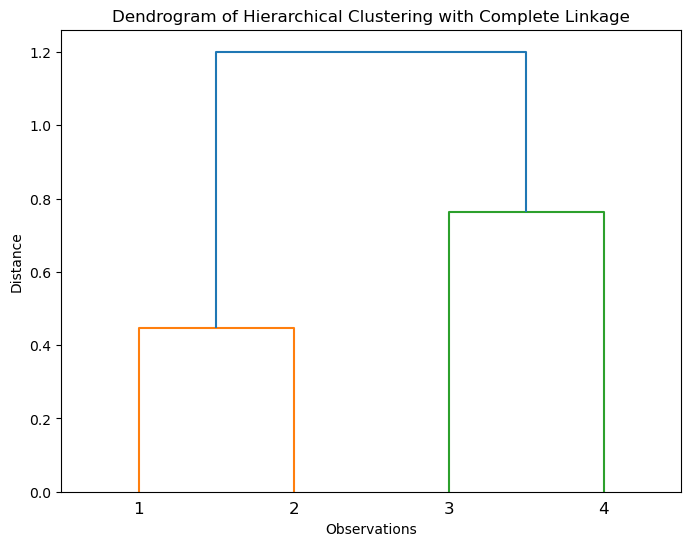

In [90]:
# (a) On the basis of this dissimilarity matrix, sketch the dendrogram that results from hierarchically clustering these four observations using complete linkage. Be sure to indicate on the plot the height at which each fusion occurs, as well as the observations corresponding to each leaf in the dendrogram.

# Perform hierarchical clustering
Z = linkage(data, method='complete')

# Plot the dendrogram
plt.figure(figsize=(8, 6))
dendrogram(Z, labels=['1', '2', '3', '4'])
plt.title('Dendrogram of Hierarchical Clustering with Complete Linkage')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.show()

/var/folders/h1/r_7yspw94w77hrsrcwzwy75m0000gn/T/ipykernel_6944/1837739702.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_single = linkage(data, method='single')


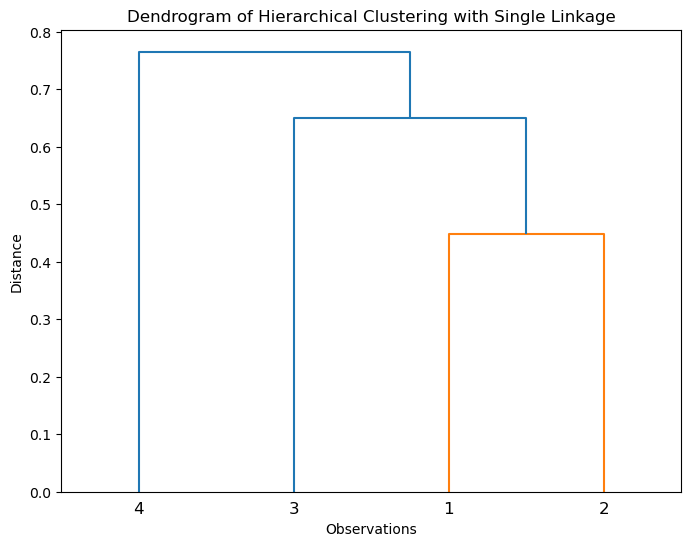

In [92]:
# (b) Repeat (a), this time using single linkage clustering

# Perform hierarchical clustering using single linkage
Z_single = linkage(data, method='single')

# Plot the dendrogram for single linkage
plt.figure(figsize=(8, 6))
dendrogram(Z_single, labels=['1', '2', '3', '4'])
plt.title('Dendrogram of Hierarchical Clustering with Single Linkage')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.show()

(c) Suppose that we cut the dendrogram obtained in (a) such that two clusters result. Which observations are in each cluster?

> Observations 1 and 2 in the first, 3 and 4 in the second.

(d) Suppose that we cut the dendrogram obtained in (b) such that two clusters result. Which observations are in each cluster?

> Observations 1, 2, and 3 in the first, observation 4 in the second.

/var/folders/h1/r_7yspw94w77hrsrcwzwy75m0000gn/T/ipykernel_6944/568161093.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(data, method='complete')


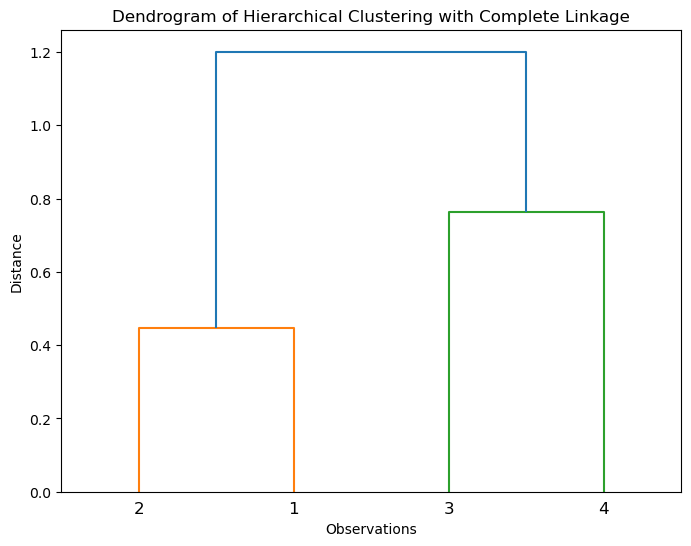

In [93]:
# (e) It is mentioned in this chapter that at each fusion in the dendrogram, the position of the two clusters being fused can be swapped without changing the meaning of the dendrogram. Draw a dendrogram that is equivalent to the dendrogram in (a), for which two or more of the leaves are repositioned, but for which the meaning of the dendrogram is the same.

# Perform hierarchical clustering
Z = linkage(data, method='complete')

# Plot the dendrogram in (a) with 1 and 2 swapped
plt.figure(figsize=(8, 6))
dendrogram(Z, labels=['2', '1', '3', '4'])
plt.title('Dendrogram of Hierarchical Clustering with Complete Linkage')
plt.xlabel('Observations')
plt.ylabel('Distance')
plt.show()

## References and Citations

- https://stackoverflow.com/questions/47606873/jupyter-no-module-named-imblearn-after-installation